In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grains/GrainSizeAnalysis_AppNote_img1.jpg


In [2]:

import cv2
from skimage import img_as_float
from skimage.util import img_as_ubyte
from matplotlib import pyplot as plt
from skimage import io
import numpy as np

from scipy import ndimage as nd

# Specify the path to your image using the Kaggle dataset path
image_path = '/kaggle/input/grains/GrainSizeAnalysis_AppNote_img1.jpg'

img=img_as_float(io.imread(image_path,0))

#denoishing the image

#using gaussian filter
gauss_img=nd.gaussian_filter(img, sigma=2)
plt.imsave('/kaggle/working/new_img.jpg', gauss_img)

from IPython.display import Image, display

saved_image_path = '/kaggle/working/new_img.jpg'


#using median filter
median_img=nd.median_filter(img,size=2)
plt.imsave('/kaggle/working/new_img2.jpg', median_img)

saved_image2_path = '/kaggle/working/new_img2.jpg'





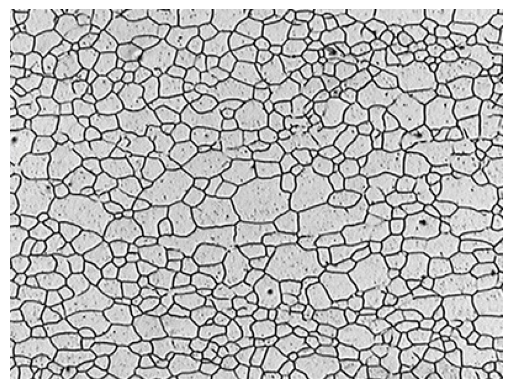

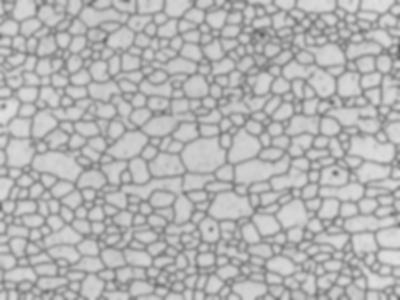

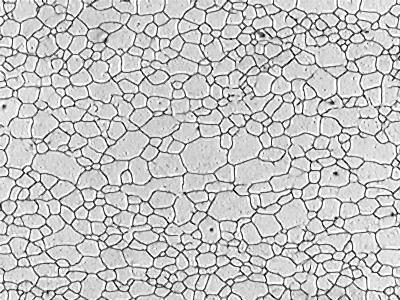

In [3]:
#Display actual image
plt.imshow(img)
plt.axis('off')
plt.show()

# Display the gaussian  image
display(Image(filename=saved_image_path))

# Display the median image
display(Image(filename=saved_image2_path))

In [4]:
print(img.shape)

(300, 400, 3)


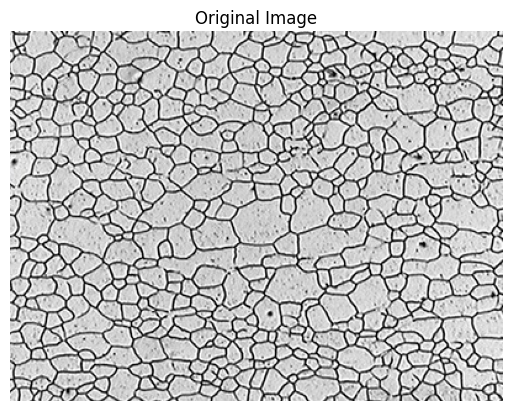

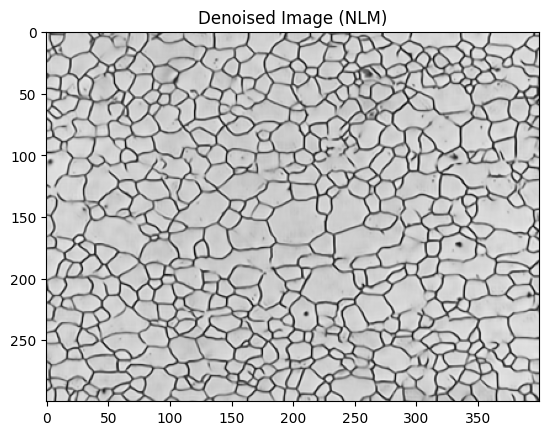

In [5]:

from skimage.restoration import denoise_nl_means,estimate_sigma
sigma_est = np.mean(estimate_sigma(img, channel_axis=-1))

patch_kw = dict(patch_size=5,      
                patch_distance=3,)

denoise_img = denoise_nl_means(img, h=5* sigma_est, 
                fast_mode=False,patch_size=5, patch_distance=3)

denoised_image = img_as_ubyte(denoise_img)

# Visualize the original and denoised images
#discplay actual imag
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()
#display denoished img
plt.imshow(denoise_img)
plt.title('Denoised Image (NLM)')
plt.imsave('/kaggle/working/denoished.jpg', denoised_image)

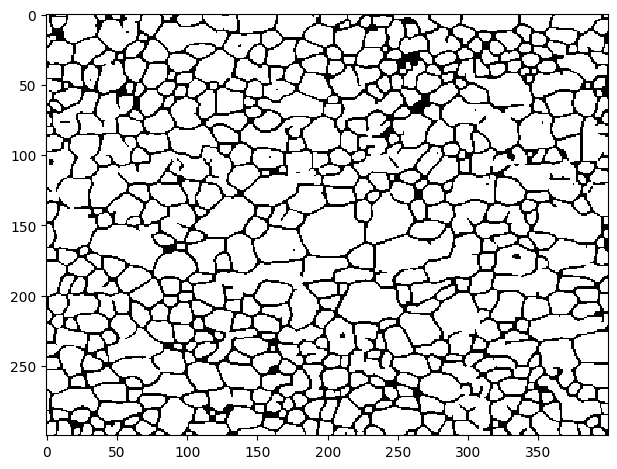

In [6]:

from skimage import measure, color, io

# Convert the denoised image to grayscale
denoised_gray = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)
# Apply Otsu's thresholding
ret, thresh = cv2.threshold(denoised_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


kernel = np.ones((3,3),np.uint8) 
eroded = cv2.erode(thresh,kernel,iterations = 1)
dilated = cv2.dilate(eroded,kernel,iterations = 1)
mask = dilated == 255 

io.imshow(mask)

s = [[1,1,1],[1,1,1],[1,1,1]]


labeled_mask, num_labels = nd.label(mask, structure=s)

#The function outputs a new image that contains a different integer label 
#for each object, and also the number of objects found.



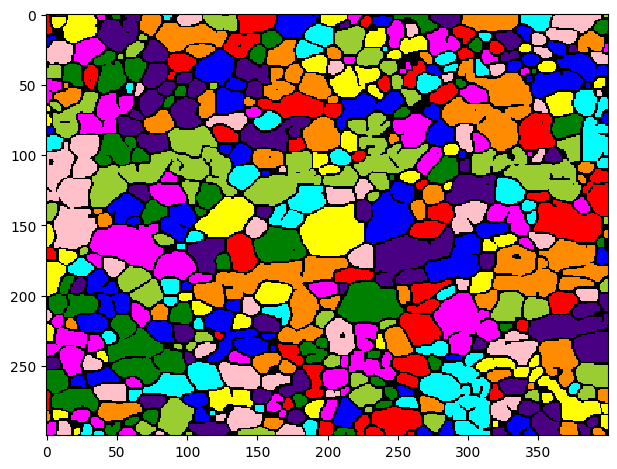

In [7]:

#Let's color the labels to see the effect
img2 = color.label2rgb(labeled_mask, bg_label=0)

io.imshow( img2)
io.show()

In [8]:

#Step 5: Measure the properties of each grain (object)

# regionprops function in skimage measure module calculates useful parameters for each object.

clusters = measure.regionprops(labeled_mask, img2)  #send in original image for Intensity measurements


In [9]:
  
#Step 6: Output results into a csv file   
#Best way is to output all properties to a csv file
    
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    


In [10]:

output_file = open('image_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

120

In [11]:
pixel_size = 0.5
with open('output.csv', 'w') as output_file:  # Open the file for writing
    for cluster_props in clusters:
        # Output cluster properties to the excel file
        output_file.write(str(cluster_props['Label']))
        for i, prop in enumerate(propList):
            if prop == 'Area': 
                to_print = cluster_props[prop] * pixel_size ** 2  # Convert pixel square to um square
            elif prop == 'orientation': 
                to_print = cluster_props[prop] * 57.2958  # Convert to degrees from radians
            elif prop.find('Intensity') < 0:  # Any prop without Intensity in its name
                to_print = cluster_props[prop] * pixel_size
            else: 
                to_print = cluster_props[prop]  # Remaining props, basically the ones with Intensity in its name
            output_file.write(',' + str(to_print))
        output_file.write('\n')

# The file will be automatically closed when exiting the 'with' block


In [12]:
total_area = 0
num_clusters = len(clusters)

# Iterate through each cluster and sum up the areas
for cluster_props in clusters:
    total_area += cluster_props['Area']  # Assuming 'Area' is the key for area in cluster_props



# Calculate the average area
average_area = total_area / num_clusters

print("Final Average Area: ", average_area)

Final Average Area:  218.61252900232017
